In [1]:
import razor
import razor.flow as rf
from razor import api
from razor.flow.spark import SparkBlock, SparkExecutor


In [2]:
import os
from datetime import datetime, timedelta
from pyspark.sql import SparkSession, functions
from pyspark.sql.dataframe import DataFrame
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pyspark.sql.types import IntegerType, DateType, ArrayType, StringType, FloatType, TimestampType


In [3]:
from razor.project.blocks.ayan_spark_blocks import MercStatic
from razor.project.blocks.ayan_spark_blocks import ReadCsvProjectSpace
from razor.project.blocks.ayan_spark_blocks import TranCityTS
from razor.project.blocks.ayan_spark_blocks import TranTypeTS
from razor.project.blocks.ayan_spark_blocks import NonSparkPath
from razor.project.blocks.ayan_spark_blocks import CustStatic
from razor.project.blocks.ayan_spark_blocks import ProdTypeTS
from razor.project.blocks.ayan_spark_blocks import CustMercTS
from razor.project.blocks.ayan_spark_blocks import DropDuplicates

In [4]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)


In [5]:
@rf.block
class Concat(SparkBlock):
    
    df1: DataFrame
    df2: DataFrame
    cols: list
    op_df: rf.Output[DataFrame]
    
    def run(self):
        merged_df = self.df1.join(self.df2, on=self.cols, how='inner')
        self.op_df.put(merged_df)
        

In [6]:
nsp = NonSparkPath(ip_path='customer_data.csv')

In [7]:
rcp = ReadCsvProjectSpace(filename = nsp.op_path, config={}, source="")
rcp.executor = SparkExecutor

In [8]:
cs = CustStatic(ip_data = rcp.data, config={}, source="")
cs.executor = SparkExecutor

In [9]:
drp = DropDuplicates(ip_data = cs.customer_static, config={}, source="")
drp.executor = SparkExecutor

In [10]:
ms = MercStatic(ip_data = rcp.data, config={}, source="")
ms.executor = SparkExecutor

In [11]:
cm_ts = CustMercTS(ip_data = rcp.data, config={}, source="")
cm_ts.executor = SparkExecutor

In [12]:
pt_ts = ProdTypeTS(ip_data = rcp.data, config={}, source="")
pt_ts.executor = SparkExecutor

In [13]:
tc_ts = TranCityTS(ip_data = rcp.data, config={}, source="")
tc_ts.executor = SparkExecutor

In [14]:
tt_ts = TranTypeTS(ip_data = rcp.data, config={}, source="")
tt_ts.executor = SparkExecutor

In [15]:
merged_cust = Concat(df1=cm_ts.customer_ts, df2=cs.customer_static, cols=["card_number","customer_name"])
merged_merc = Concat(df1=cm_ts.merchant_ts, df2=ms.merchant_static, cols=["merchant_id","merchant_city","merchant_state"])


In [16]:
pipe = rf.Pipeline('temp', targets = [merged_cust, merged_merc, pt_ts, tc_ts, tt_ts])

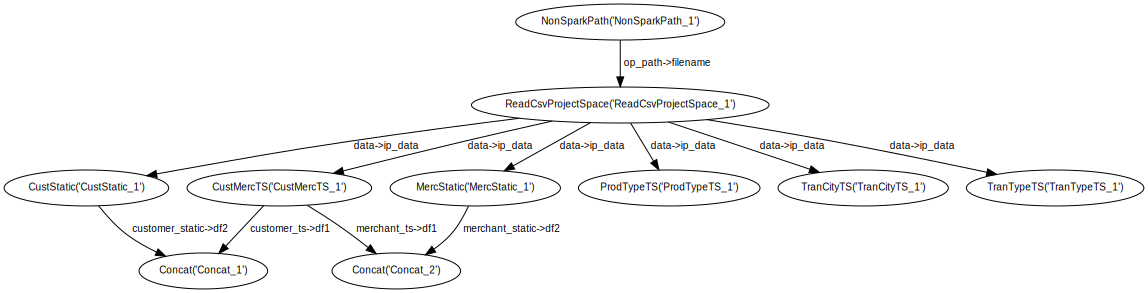

In [17]:
pipe

In [18]:
pipe.execute()

log path: /tmp/tmp3bms_v5z/temp


{}